In [1]:
from ml_battery import *
import sklearn.pipeline
import pickle
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.svm
import sklearn.linear_model
import sklearn.cross_validation
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\ProgramData\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
USE_PRETRAINED = False

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(np.hstack((data.data,data.target.reshape((-1,1)))), columns=(data.feature_names+["target"]))
data_train, data_test = sklearn.cross_validation.train_test_split(df, test_size=0.2, random_state=0)

In [4]:
X_train, y_train = data_train.drop("target", axis=1), data_train[["target"]]
X_test, y_test = data_test.drop("target", axis=1), data_test[["target"]]
weights_train, weights_test = np.ones(X_train.shape[0]), np.ones(X_test.shape[0])

In [5]:
codebook = pd.DataFrame(columns=["Name","Type"]).set_index("Name")

In [6]:
clf = sklearn.pipeline.Pipeline([
    ('data_transformation', CodebookTransformer(codebook, X_possible_values = df)),
    ('feature_selection', SelectFromModelPandas(sklearn.ensemble.RandomForestClassifier())),
    ('classification', StackedClassifier(
        MultiClassifier([
            ("random forest", HyperparameterOptimizedClassifier(sklearn.ensemble.RandomForestClassifier(), max_depth=(2,10))),
            ("logistic regression", sklearn.linear_model.LogisticRegression(C=100000)),
            ("one-hidden mlp, 1000 epochs, optimized hidden", HyperparameterOptimizedClassifier(OneLayerNNClassifier(n_epochs=1000, regularization=0.01, dropout=1), parallel=True, n_hidden=(1,100))),
            #("linear SVC", sklearn.svm.LinearSVC(C=100000)),
            #("rbf SVC", sklearn.svm.SVC(kernel="rbf")),
            #("linear regression (rounded to nearest int)", IntegerRegressor(sklearn.linear_model.LinearRegression())),
            ("naive bayes", MixedNB()),
            #("one-hidden MLP, 1000 epochs, 20 hidden", OneLayerNNClassifier(20, 1000, batch_size=300, learning_rate=0.001)),
            #("one-hidden MLP, 1000 epochs, 1 hidden", OneLayerNNClassifier(1,1000)),
            #("one-hidden MLP, 10000 epochs, 1 hidden", OneLayerNNClassifier(1,10000)),
            ("stratified dummy", PatchedDummy()),
            #("nested logit", NestedClassifier(sklearn.linear_model.LogisticRegression(C=1000), (0, (1,2)))),
            #("ordered probit", OrdinalRegression("probit")),
        ], parallel=True),
        sklearn.linear_model.LogisticRegression(C=100000))),
])

In [7]:
if USE_PRETRAINED:
    with open("../models/iris_pipeline4.p","rb") as f:
        iris_pipeline = pickle.load(f)
    clf=iris_pipeline
else:
    #with open("../logs/iris_pipeline2.log","w") as log:
    #    with LogStdout(log):
    clf.fit(X_train, y_train, classification__sample_weight=weights_train)
    with open("../models/iris_pipeline4.p","wb") as f:
        pickle.dump(clf,f)


C:\ProgramData\Anaconda\lib\site-packages\sklearn\feature_selection\from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
multiclf = sklearn.pipeline.Pipeline(clf.steps[:2] + [("classifier", clf.steps[2][1].multiestimator)])

In [9]:
clf.score(X_test, y_test, sample_weight=weights_test)

C:\ProgramData\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((accuracy                                       0.966667
  weighted f1                                    0.965769
  weighted precision                             0.969048
  weighted recall                                0.966667
  macro f1                                       0.957351
  macro precision                                0.976190
  macro recall                                   0.944444
  log loss                                       0.311287
  macro mean absolute market share error         0.243590
  weighted mean absolute market share error      0.066667
  training time                                510.832102
  dtype: float64,       0.0   1.0  2.0
  0.0  11.0   0.0  0.0
  1.0   0.0  13.0  0.0
  2.0   0.0   1.0  5.0, petal length (cm)    0.40
  petal width (cm)     0.38
  dtype: float64),
 (                                           logistic regression  naive bayes  \
  accuracy                                              0.966667     1.000000   
  weighted f1     

In [10]:
pred_stacked = clf.predict(X_test)
pred = multiclf.predict(X_test)

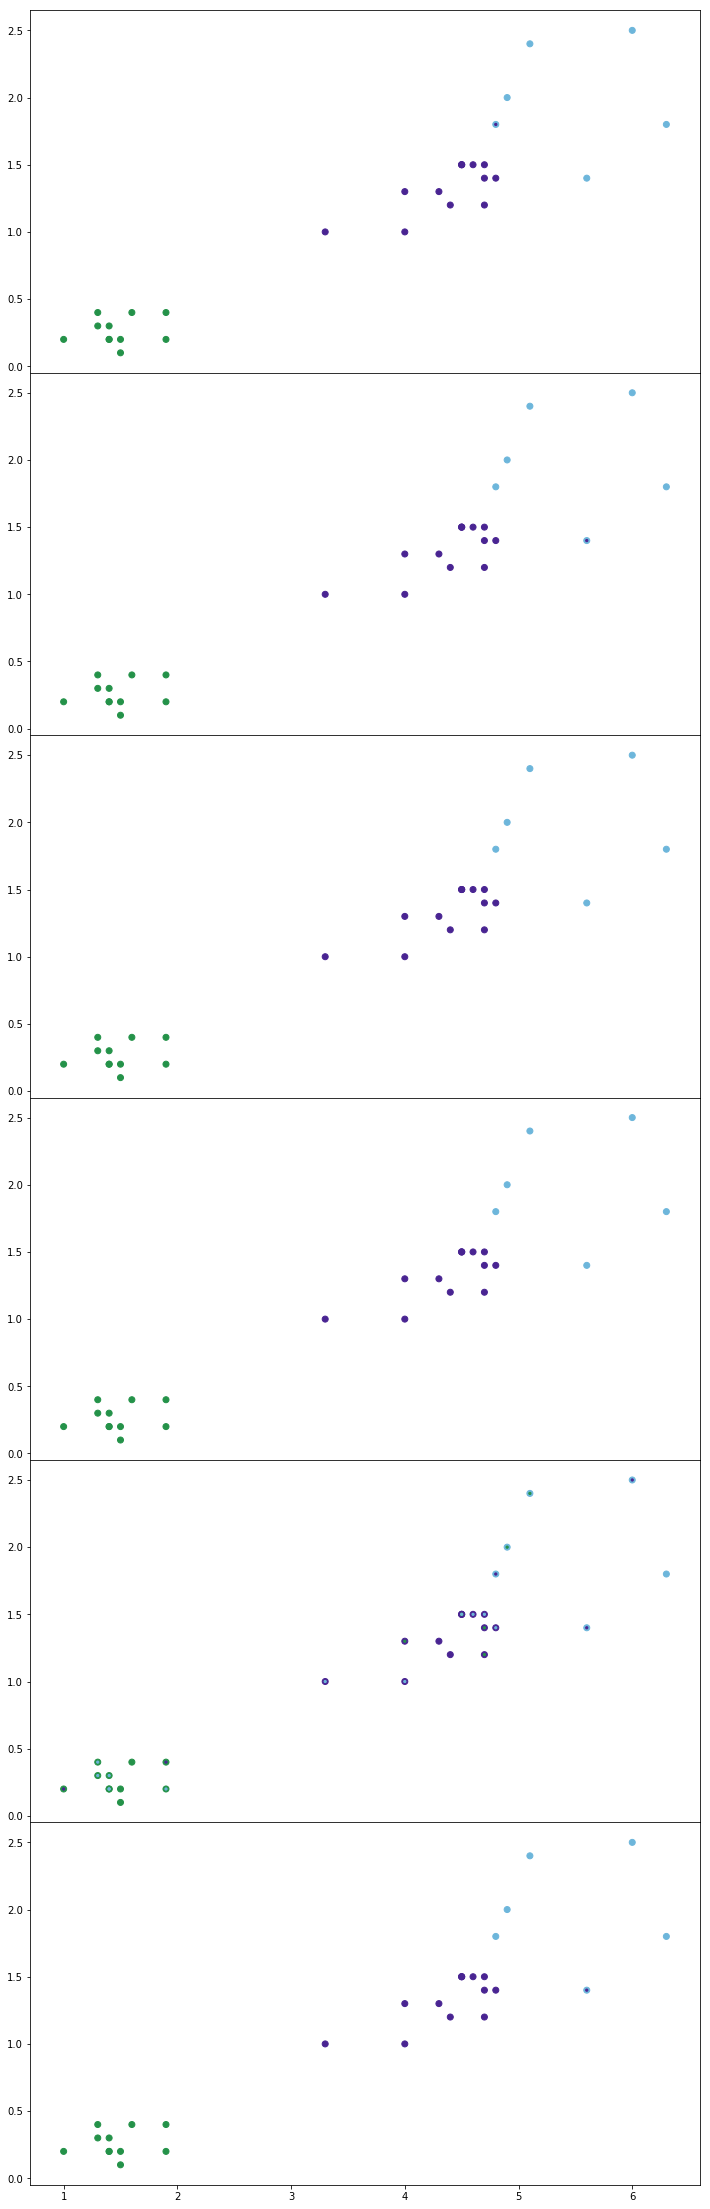

In [11]:
f, axes = plt.subplots(len(clf.steps[2][1].multiestimator.estimators)+1, sharex=True, sharey=True, figsize=(12,40))
for ax in axes:
    ax.scatter(X_test["petal length (cm)"], X_test["petal width (cm)"], c=cmap(y_test.iloc[:,0]))
for i in range(len(axes)-1):
    axes[i].scatter(X_test["petal length (cm)"], X_test["petal width (cm)"], c=cmap(pred[i][1].flatten()), s=5)
axes[-1].scatter(X_test["petal length (cm)"], X_test["petal width (cm)"], c=cmap(pred_stacked), s=5)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

In [12]:
pred_stacked = clf.predict(X_train)
pred = multiclf.predict(X_train)

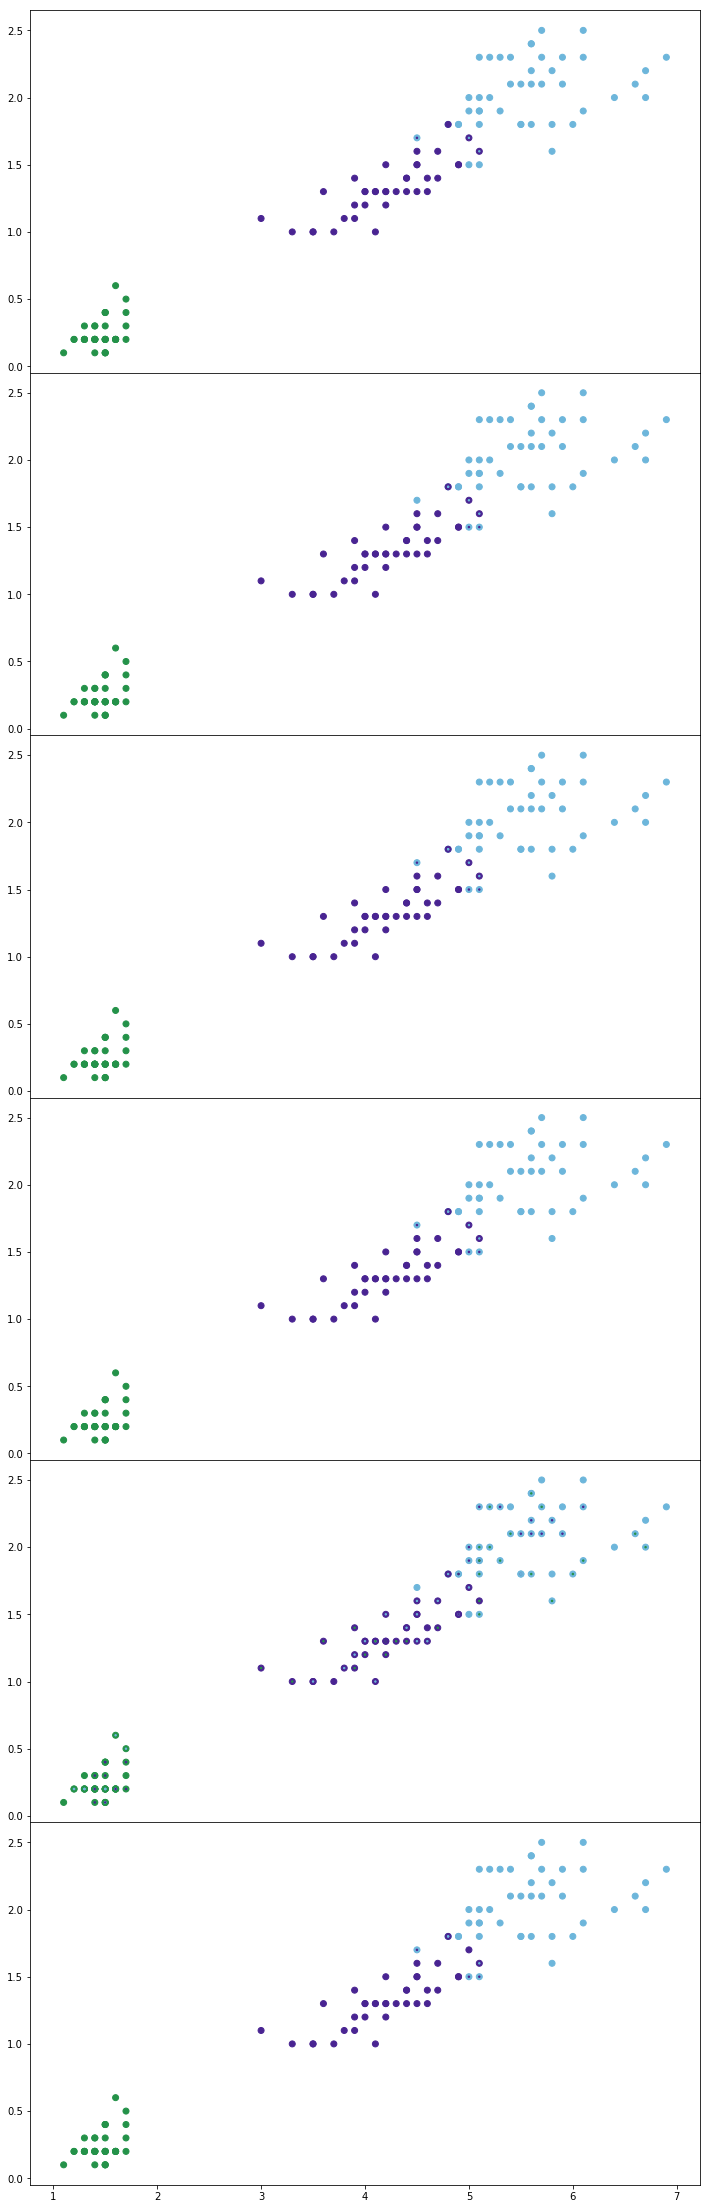

In [13]:
f, axes = plt.subplots(len(clf.steps[2][1].multiestimator.estimators)+1, sharex=True, sharey=True, figsize=(12,40))
for ax in axes:
    ax.scatter(X_train["petal length (cm)"], X_train["petal width (cm)"], c=cmap(y_train.iloc[:,0]))
for i in range(len(axes)-1):
    axes[i].scatter(X_train["petal length (cm)"], X_train["petal width (cm)"], c=cmap(pred[i][1].flatten()), s=2)
axes[-1].scatter(X_train["petal length (cm)"], X_train["petal width (cm)"], c=cmap(pred_stacked), s=2)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

In [14]:
g = np.mgrid[0:7:0.05, 0:3:0.02]
xx = np.vstack(map(np.ravel, g)).T
xx = np.hstack((np.ones((xx.shape[0],2)), xx)) #garbage columns
xx = pd.DataFrame(xx,columns=X_train.columns)

In [15]:
pred_stacked = clf.predict(xx)
pred = multiclf.predict(xx)

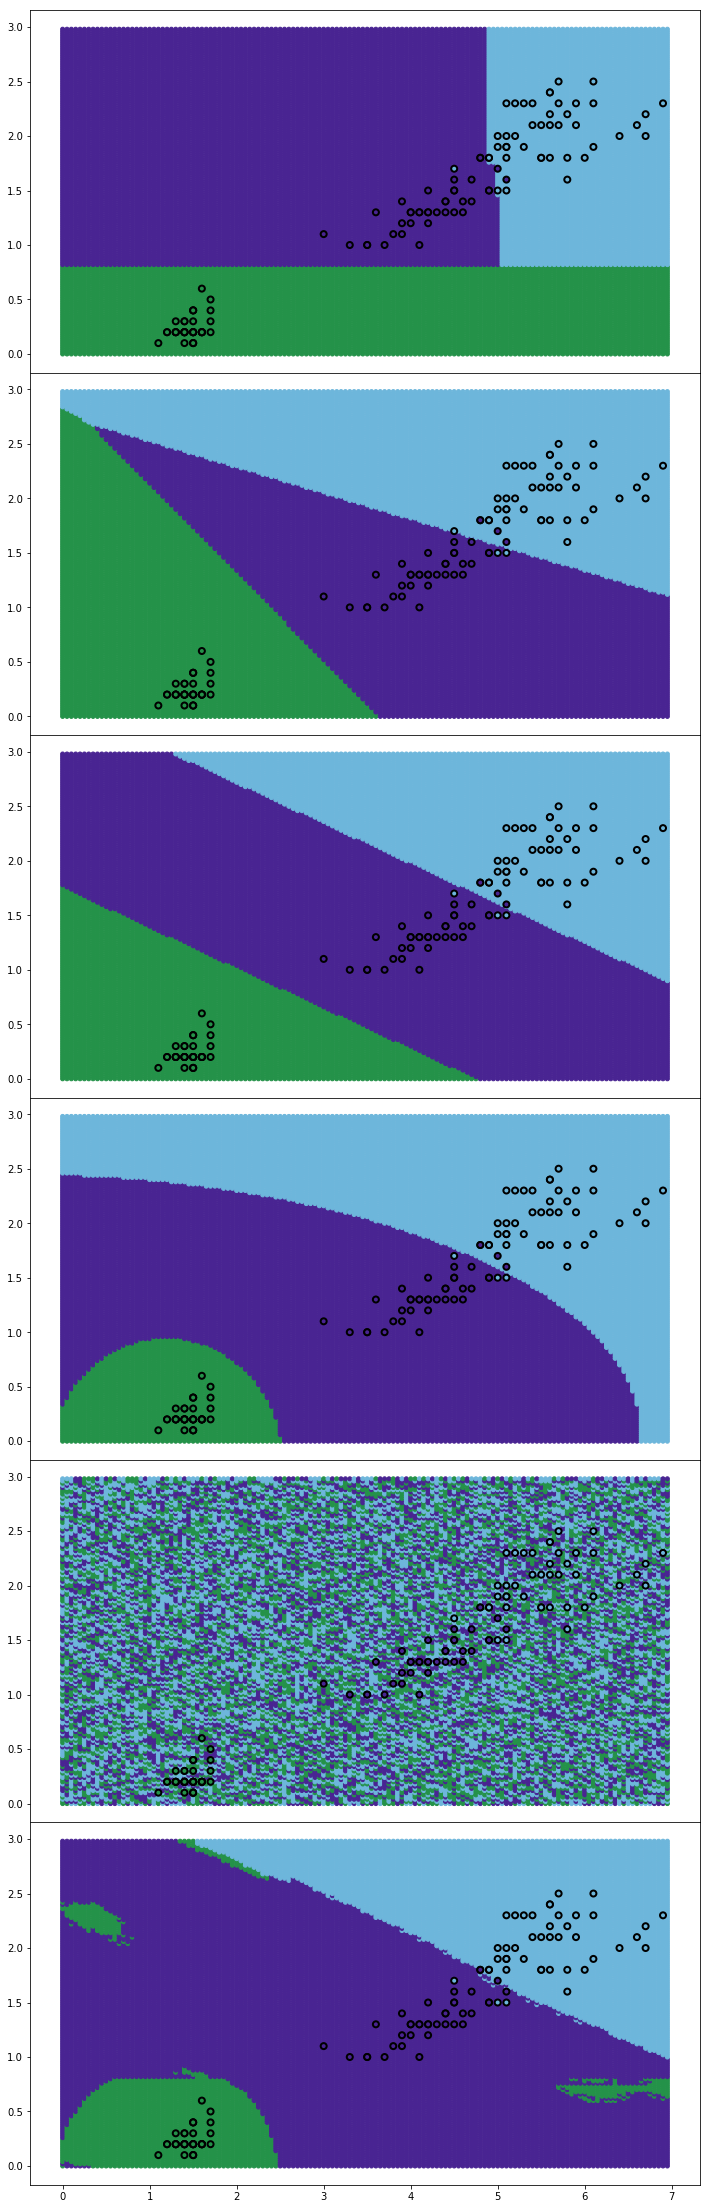

In [16]:
f, axes = plt.subplots(len(clf.steps[2][1].multiestimator.estimators)+1, sharex=True, sharey=True, figsize=(12,40))
for i in range(len(axes)-1):
    axes[i].scatter(xx.iloc[:,2], xx.iloc[:,3], c=cmap(pred[i][1]), s=16)
axes[-1].scatter(xx.iloc[:,2], xx.iloc[:,3], c=cmap(pred_stacked), s=16)
for ax in axes:
    ax.scatter(X_train["petal length (cm)"], X_train["petal width (cm)"], c=cmap(y_train.iloc[:,0]), linewidths=2, edgecolors="k")


f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.show()

In [17]:
clf.score(X_test, y_test)

C:\ProgramData\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


((accuracy                                       0.966667
  weighted f1                                    0.965769
  weighted precision                             0.969048
  weighted recall                                0.966667
  macro f1                                       0.957351
  macro precision                                0.976190
  macro recall                                   0.944444
  log loss                                       0.278816
  macro mean absolute market share error         0.243590
  weighted mean absolute market share error      0.066667
  training time                                510.832102
  dtype: float64,      0.0  1.0  2.0
  0.0   11    0    0
  1.0    0   13    0
  2.0    0    1    5, petal length (cm)    0.333333
  petal width (cm)     0.386667
  dtype: float64),
 (                                           logistic regression  naive bayes  \
  accuracy                                              0.966667     1.000000   
  weighted f1     

In [18]:
clf.steps[2][1].multiestimator.estimators

[('random forest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=2, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)),
 ('logistic regression',
  LogisticRegression(C=100000, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False)),
 ('one-hidden mlp, 1000 epochs, optimized hidden',
  OneLayerNNClassifier(batch_size=None, dropout=1, learning_rate=0.01,
             n_epochs=1000, n_hidden=77, regularization=0.01, trainable=True)),
 ('naive bayes', MixedNB()),
 ('stratified

In [19]:
(stacked_scores, stacked_cm, stacked_fi), (multi_scores, multi_cm, multi_fi) = clf.score(X_test, y_test)

C:\ProgramData\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
stacked_scores

accuracy                                       0.966667
weighted f1                                    0.965769
weighted precision                             0.969048
weighted recall                                0.966667
macro f1                                       0.957351
macro precision                                0.976190
macro recall                                   0.944444
log loss                                       0.288016
macro mean absolute market share error         0.243590
weighted mean absolute market share error      0.066667
training time                                510.832102
dtype: float64

In [21]:
multi_scores["stacked model"] = stacked_scores

In [22]:
multi_scores

,logistic regression,naive bayes,"one-hidden mlp, 1000 epochs, optimized hidden",random forest,stratified dummy,stacked model
accuracy,0.966667,1.000000,1.000000,0.966667,0.333333,0.966667
weighted f1,0.965769,1.000000,1.000000,0.965769,0.343333,0.965769
weighted precision,0.969048,1.000000,1.000000,0.969048,0.412698,0.969048
weighted recall,0.966667,1.000000,1.000000,0.966667,0.333333,0.966667
macro f1,0.957351,1.000000,1.000000,0.957351,0.333333,0.957351
macro precision,0.976190,1.000000,1.000000,0.976190,0.373016,0.976190
macro recall,0.944444,1.000000,1.000000,0.944444,0.360140,0.944444
log loss,0.166407,0.022927,0.160052,0.127583,26.479729,0.288016
macro mean absolute market share error,0.243590,0.000000,0.000000,0.243590,1.976690,0.243590
weighted mean absolute market share error,0.066667,0.000000,0.000000,0.066667,0.533333,0.066667


In [23]:
print(multi_scores.round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  logistic regression &  naive bayes &  one-hidden mlp, 1000 epochs, optimized hidden &  random forest &  stratified dummy &  stacked model \\
\midrule
accuracy                                  &                0.967 &        1.000 &                                           1.00 &          0.967 &             0.333 &          0.967 \\
weighted f1                               &                0.966 &        1.000 &                                           1.00 &          0.966 &             0.343 &          0.966 \\
weighted precision                        &                0.969 &        1.000 &                                           1.00 &          0.969 &             0.413 &          0.969 \\
weighted recall                           &                0.967 &        1.000 &                                           1.00 &          0.967 &             0.333 &          0.967 \\
macro f1                                  &                0.957 &

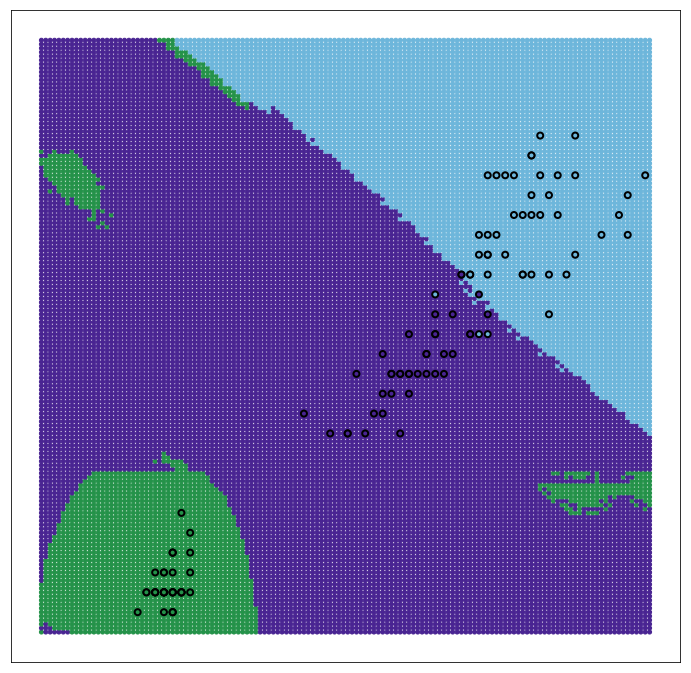

In [24]:
f = plt.figure(figsize=(12,12))
plt.scatter(xx.iloc[:,2], xx.iloc[:,3], c=cmap(pred_stacked), s=16)
plt.scatter(X_train["petal length (cm)"], X_train["petal width (cm)"], c=cmap(y_train.iloc[:,0]), linewidths=2, edgecolors="k")

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

f.savefig('iris_stacked.eps', format='eps')
f.savefig('iris_stacked.png', format='png')
plt.show()

In [25]:
y_train["target"].value_counts()

2.0    44
0.0    39
1.0    37
Name: target, dtype: int64

In [26]:
clf.steps[2][1].multiestimator.estimators[3][1]

MixedNB()

In [27]:
(stacked_scores, stacked_cm, stacked_fi), (multi_scores, multi_cm, multi_fi) = clf.score(X_train, y_train)
multi_scores

C:\ProgramData\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,logistic regression,naive bayes,"one-hidden mlp, 1000 epochs, optimized hidden",random forest,stratified dummy
accuracy,0.958333,0.950000,0.950000,0.966667,0.350000
weighted f1,0.958282,0.950000,0.950000,0.966667,0.350210
weighted precision,0.958426,0.950000,0.950000,0.966667,0.350620
weighted recall,0.958333,0.950000,0.950000,0.966667,0.350000
macro f1,0.958442,0.950246,0.950246,0.966830,0.350096
macro precision,0.959259,0.950246,0.950246,0.966830,0.350898
macro recall,0.957821,0.950246,0.950246,0.966830,0.349488
log loss,0.228515,0.081792,0.151426,0.108732,23.025851
macro mean absolute market share error,0.049754,0.000000,0.000000,0.000000,0.098123
weighted mean absolute market share error,0.016667,0.000000,0.000000,0.000000,0.033333
